<a href="https://colab.research.google.com/github/Heeralall/cloud-computing-predict/blob/main/Copy_of_Data_profiling_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Big Data - Data profiling

© Explore Data Science Academy

## Honour Code
I {Koben Heeralall}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).
    Non-compliance with the honour code constitutes a material breach of contract.

## Context

Having completed the first step - data ingestion, the data now needs to be thoroughly prepared so that it is readable, reliable and robust. As the Data Engineer in the team, this will be your responsibility. The Data Scientists are looking to you to clean this data so that model development and deployment become seamless when the data is used in a production environment. Having completed your Data Engineering course recently, your manager Gnissecorp Atadgid, asks you to create data summaries and perform checks using the six dimensions of data quality.

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://github.com/Explore-AI/Pictures/raw/master/data_engineering/transform/predict/DataQuality.jpg"
     alt="Data Quality"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. Six dimensions of data quality</em></p>
</div>

### Upload from local
The following cell is to upload a file from your local machine to Google Colab. You will have a dialogue box as indicated where you will select the file and have it uploaded to the notebook.

In [1]:
"""
This cell is used to import data/files from your local machine to colab
"""
from google.colab import files
uploaded = files.upload()

Saving part-00001-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet to part-00001-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet
Saving part-00000-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet to part-00000-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Colab is essentially running on a linux machine on Google Cloud Platform.
This means that should you want to install something in your notebook you
would have to run headless installs as well as wget. Copying the installs
below will ensure that you have spark and java installed in the environment
as well as available for the notebook.
"""
!apt-get install openjdk-17-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
"""
This section helps in rendering your notebook operable and ensuring that
your environment variables for spark are correct. Running this cell in any
notebook allows for any unresolved spark environment to be fixed.
"""
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [4]:
"""
We need to locate Spark in the system. For that, we import findspark and
use the findspark.init() method. If you want to know the location where
Spark is installed, use findspark.find()
"""
import findspark
findspark.init()
findspark.find()
import pyspark

## Import libraries
Below we import the libraries required to complete this section of the predict.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

Remember that we need a `SparkContext` and `SparkSession` to interface with Spark.
We will mostly be using the `SparkContext` to interact with RDDs
and the `SparkSession` to interface with Python objects.

> ℹ️ **Instructions** ℹ️
>
>Initialise a new **Spark Context** and **Session** that you will use to interface with Spark.

In [6]:
#TODO: Write your code here.
# Create SparkContext
sc = SparkContext()

# Create SparkSession
spark = SparkSession \
    .builder \
    .appName("2403PTDEKOBHEE") \
    .getOrCreate()

## Parquet files
In the previous section of the predict, you generated parquet files to your local directory. You will be making use of these files to continue with this section of the predict. Please make sure that your parquet files are specifically for the year **1962**. Any other year used outside of **1962** will produce incorrect answers and have a negative impact on your overall predict mark.

> ℹ️ **Instructions** ℹ️
>
> Read the parquet files stored in your directory for the year **1962** into a Spark DataFrame.

In [7]:
#TODO: Write your code here
parquet_files1 = "/content/part-00000-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet"
parquet_files2 = "/content/part-00001-52e1da7d-39e6-46bc-8167-46297b52948b-c000.snappy.parquet"

df = spark.read.parquet(parquet_files1,parquet_files2 )

## Metadata

Metadata is data containing additional information about the data itself. In the cloud storage, there is a metadata file called [`symbols_valid_meta.csv`](https://processing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com/symbols_valid_meta.csv) that is collocated with the stock market data. You will need to download this to use when performing your data quality checks.

> ℹ️ **Instructions** ℹ️
>
> Download the metadata from the S3 bucket and read it into a Spark DataFrame.

In [8]:
#TODO: Write your code here
import pandas as pd
# Read the CSV file using pandas
metadata_pd = pd.read_csv('https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fprocessing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com%2Fsymbols_valid_meta.csv')
# Convert the pandas DataFrame to a Spark DataFrame
metadata = spark.createDataFrame(metadata_pd)


## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Instructions** ℹ️
>
> Generate summary statistics to explore your data. Make sure you understand the ranges, means, extremums, and deviations found in the data set.

In [9]:
#TODO: Write your code here
df.describe().show()


+-------+------------------+------------------+-------------------+--------------------+------------------+-----------------+-----+
|summary|              open|              high|                low|               close|            volume|        adj_close|stock|
+-------+------------------+------------------+-------------------+--------------------+------------------+-----------------+-----+
|  count|              5106|              5106|               5064|                5106|              4833|             5085| 5106|
|   mean|1.0904873526012002|16.757624946793637| 15.728619917198033|   16.64199179044607| 6.057314297537761|540930.2458210423| NULL|
| stddev| 2.364453525304909|53.914073481935446| 51.322922898144014|   53.54677139900802|25.178942061410506|864596.2440525506| NULL|
|    min|               0.0|               0.0|0.05237788334488869|0.053624976426362984|                 0|              0.0|   AA|
|    max|              20.0|             287.5|              282.5|         

> ℹ️ **Instructions** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values.
>
>*You may use as many coding cells as necessary.*

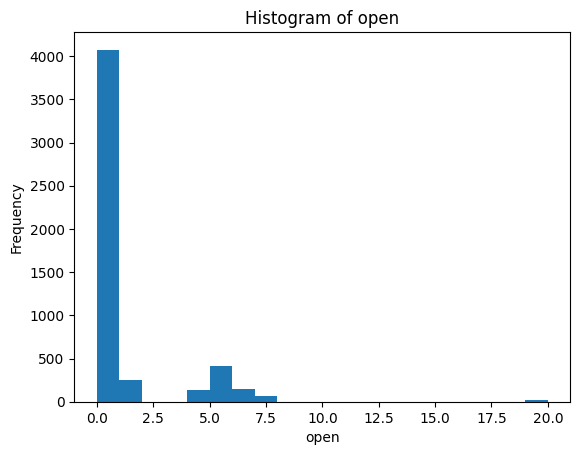

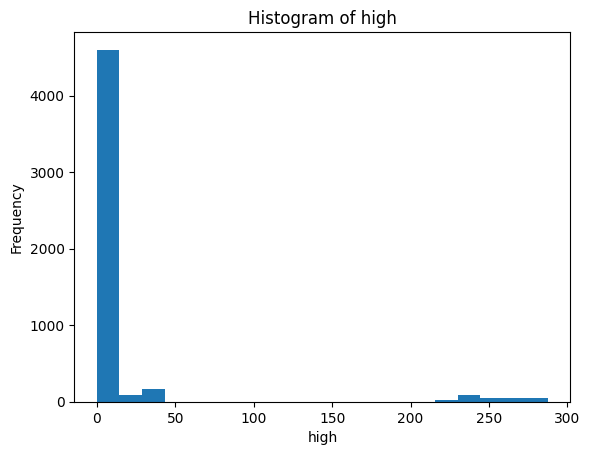

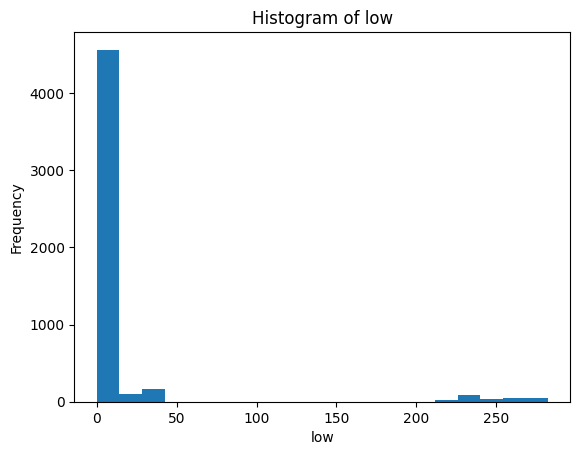

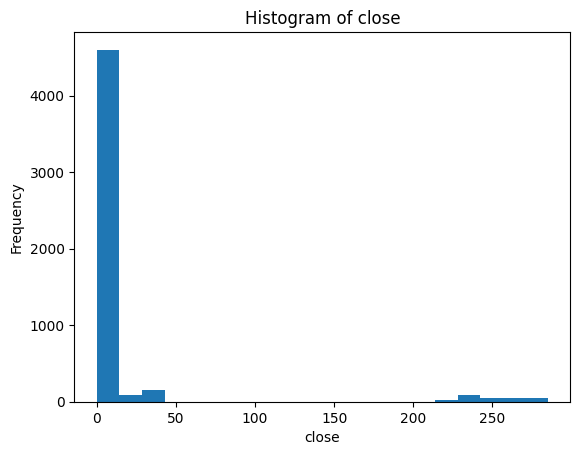

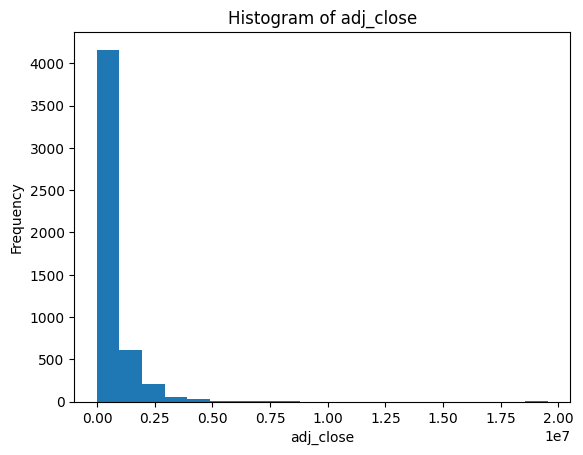

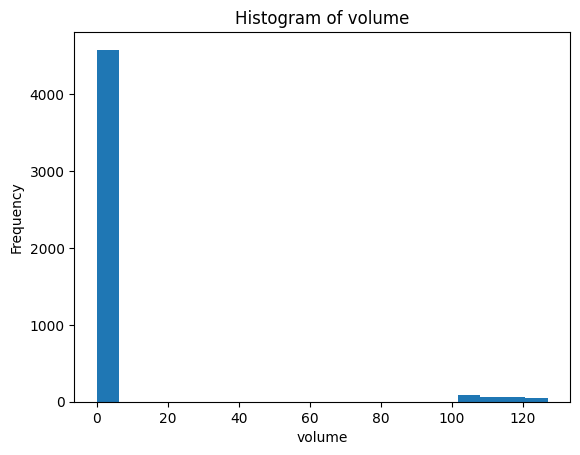

In [10]:
#TODO: Write your code here
import matplotlib.pyplot as plt

# Assuming the numerical columns are: open, high, low, close, adj_close, volume
numerical_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Loop through numerical columns and generate histograms
for col in numerical_cols:
    # Convert Spark DataFrame column to Pandas Series
    data = df.select(col).toPandas()[col]

    # Drop NaN values from the data before plotting
    data = data.dropna()

    # Create histogram using matplotlib
    plt.hist(data, bins=20)  # Adjust 'bins' for desired granularity
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


> ℹ️ **Instructions** ℹ️
>
> Investigate the **open** column to identify stocks that have open values greater than 2, and note any anomalies that you find in the data.
>
>*You may use as many coding cells as necessary.*

In [11]:
#TODO: Write your code here
# Filter for stocks with open values greater than 2
open_greater_than_2 = df.filter(df['open'] > 2)

# Display the results
open_greater_than_2.show(5)

# Optionally, group by stock and count occurrences
open_greater_than_2.groupBy('stock').count().show(5)

+----------+-----------------+------------------+-----------------+-----------------+------+---------+-----+
|      date|             open|              high|              low|            close|volume|adj_close|stock|
+----------+-----------------+------------------+-----------------+-----------------+------+---------+-----+
|1962-02-19|5.839290142059326| 5.907374858856201|5.839290142059326|5.863319873809815|     1|  29900.0|   AA|
|1962-02-19|5.481634140014648|5.5284857749938965|5.481634140014648|5.516772747039795|     1|  32000.0| ARNC|
|1962-02-19|7.260000228881836| 7.293333530426025|7.173333168029785|7.186666488647461|     0| 280000.0|  IBM|
|1962-02-14|5.839290142059326| 5.839290142059326|5.747175216674805|5.807250022888184|     1|  56500.0|   AA|
|1962-02-14|5.481634140014648| 5.481634140014648|5.399643898010254|  5.4347825050354|     1|  60400.0| ARNC|
+----------+-----------------+------------------+-----------------+-----------------+------+---------+-----+
only showing top 5 

 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. duplicated open values on consecutive days despite non-zero volume
 2. "PG" ticker has multiple opening prices at 20.0 during 1962-08
 3. possible loss of data quality for "IBM" ticker due to low number of significant figures

> ℹ️ **Instructions** ℹ️
>
> Investigate **high**, **low**, **close**, and **adj_close** to determine if any stocks may be deviating from the normal ranges of the data set. Note down the stock(s) that you come across.
>
>*You may use as many coding cells as necessary.*

In [12]:
#TODO: Write your code here
import pyspark.sql.functions as F

# Define a function to calculate the IQR and bounds
def calculate_outlier_bounds(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Loop through the columns and identify outliers
for column in ['high', 'low', 'close', 'adj_close']:
    lower_bound, upper_bound = calculate_outlier_bounds(df, column)
    outliers = df.filter((df[column] < lower_bound) | (df[column] > upper_bound))

    # Display the outlier stocks and their values
    print(f"Outliers in {column}:")
    outliers.select('stock', column).show(5)

Outliers in high:
+-----+-------+
|stock|   high|
+-----+-------+
|  DTE|29.9375|
|  NAV|  280.0|
|  DTE|30.1875|
|  NAV|276.875|
|  DTE|30.3125|
+-----+-------+
only showing top 5 rows

Outliers in low:
+-----+-------+
|stock|    low|
+-----+-------+
|  CVX|   20.0|
|  DTE|  29.75|
|  NAV|276.875|
|  CVX|   20.0|
|  DTE|29.6875|
+-----+-------+
only showing top 5 rows

Outliers in close:
+-----+-------+
|stock|  close|
+-----+-------+
|  DTE|29.9375|
|  NAV|279.375|
|  DTE| 29.875|
|  NAV| 273.75|
|  DTE|  30.25|
+-----+-------+
only showing top 5 rows

Outliers in adj_close:
+-----+---------+
|stock|adj_close|
+-----+---------+
|   GE|1557500.0|
|  XOM|1657600.0|
|   GE|1617400.0|
|  JNJ|2289600.0|
|  JNJ|2160000.0|
+-----+---------+
only showing top 5 rows



 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. all values of "NAV" lie at least 3.8 stddev above the mean
 2. stddev > mean (~3.2 times larger)
 3. multiple repeated values along columns for all tickers
 4. multiple 'null' values for "low" value of NAV



## Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset.

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

Completeness issues can occur at the row level (gaps within the dataset) or the field level (one entry missing). At the field level, entire fields can being empty, or >80% of a field's data missing.

Another issue that may occur is default values. A typical example of this is where a logger sends back a 0 instead of a null value, which can greatly skew any attempts at modelling. This is where it is instrumental to employ domain knowledge when assessing a dataset.

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy.

### Missing values

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of missing values (nulls) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [13]:
#TODO: Write your code here
from pyspark.sql.functions import col, count, when, isnan

from pyspark.sql.functions import col, count, when, isnan

# Calculate missing values and percentages for each column
for column in df.columns:
    # Check if the column is numeric before applying isnan
    if df.schema[column].dataType in [DoubleType(), FloatType()]:
        missing_count = df.select(count(when(isnan(column) | col(column).isNull(), column))).first()[0]
    else:
        missing_count = df.select(count(when(col(column).isNull(), column))).first()[0] # For non-numeric columns, only check for nulls
    total_count = df.count()
    percentage = (missing_count / total_count) * 100
    print(f"There are {missing_count} ({percentage:.2f}%) null values in {column} column")

There are 0 (0.00%) null values in date column
There are 0 (0.00%) null values in open column
There are 0 (0.00%) null values in high column
There are 42 (0.82%) null values in low column
There are 0 (0.00%) null values in close column
There are 273 (5.35%) null values in volume column
There are 21 (0.41%) null values in adj_close column
There are 0 (0.00%) null values in stock column


### Columns with missing values


> ℹ️ **Instructions** ℹ️
>
> From the above result, probe the columns that are affected by the missing data to find out which stocks were affected.
>
>*You may use as many coding cells as necessary.*

In [14]:
#TODO: Write your code here
from pyspark.sql.functions import col, isnan

# Loop through the columns identified as having missing values
for column_with_missing_data in ["low", "volume", "adj_close"]: # Replace with actual column names

    # Filter for rows with missing values in the current column
    missing_data_rows = df.filter(isnan(column_with_missing_data) | col(column_with_missing_data).isNull())

    # Group by stock and count occurrences of missing values
    missing_data_by_stock = missing_data_rows.groupBy("stock").count()

    # Display the results for the current column
    print(f"Missing values in {column_with_missing_data}:")
    missing_data_by_stock.show()

Missing values in low:
+-----+-----+
|stock|count|
+-----+-----+
|  CAT|   22|
|  NAV|   20|
+-----+-----+

Missing values in volume:
+-----+-----+
|stock|count|
+-----+-----+
|  JNJ|  252|
|   FL|   21|
+-----+-----+

Missing values in adj_close:
+-----+-----+
|stock|count|
+-----+-----+
|  JNJ|   21|
+-----+-----+



#### Fix Completeness

How do we deal with incomplete data?
- Dropping missing values
- Discard the incomplete column
- Discard the rows containing missing data
- Case deletion

> ℹ️ **Instructions** ℹ️
>
> Use the appropriate strategy to remedy the missing data.
>
>*You may use as many coding cells as necessary.*

In [15]:
#TODO: Write your code here
df_cleaned = df.dropna()

### Zero Values

Take a deeper look into the entries with many zero values.

#### Fix Completeness

Completeness issues can be fixed through imputation of the missing data through:
- imputation by mean/mode/median;
- regression; or
- KNN.

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of zeros (0) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_zeros> (<percentage>) zero values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [16]:
#TODO: Write your code here
from pyspark.sql.functions import col, count, when

# Calculate zero values and percentages for each column
for column in df.columns:
    # Skip the 'date' column
    if column == 'date':
        continue

    zero_count = df.select(count(when(col(column) == 0, column))).first()[0]
    total_count = df.count()
    percentage = (zero_count / total_count) * 100
    print(f"There are {zero_count} ({percentage:.2f}%) zero values in {column} column")

There are 2768 (54.21%) zero values in open column
There are 20 (0.39%) zero values in high column
There are 0 (0.00%) zero values in low column
There are 0 (0.00%) zero values in close column
There are 3825 (74.91%) zero values in volume column
There are 27 (0.53%) zero values in adj_close column
There are 0 (0.00%) zero values in stock column


From the above section, you find that there are a few columns that contain zero values. However, some of these are true zeros and are explainable. Your task is to distinguish which column should undergo data imputation.

> ℹ️ **Instructions** ℹ️
>
> Investigate the columns with zero values and determine which one should undergo data imputation. Take note of the stock and month on which zero values occurred.
>
>*You may use as many coding cells as necessary.*

In [17]:
#TODO: Write your code here
from pyspark.sql.functions import month

# Loop through the columns identified for imputation
for column_to_impute in ["open", "high", "low", "close", "adj_close"]:
    # Filter for rows with zero values in the current column
    zero_value_rows = df.filter(df[column_to_impute] == 0)

    # Extract stock and month information
    zero_occurrences = zero_value_rows.select("stock", month("date").alias("month"))

    # Display the results for the current column
    print(f"Zero values in {column_to_impute}:")
    zero_occurrences.show(5)

Zero values in open:
+-----+-----+
|stock|month|
+-----+-----+
|  CVX|    2|
|  DTE|    2|
|   ED|    2|
|   FL|    2|
|   GT|    2|
+-----+-----+
only showing top 5 rows

Zero values in high:
+-----+-----+
|stock|month|
+-----+-----+
|  CAT|   11|
|  CAT|   11|
|  CAT|   11|
|  CAT|   11|
|  CAT|   11|
+-----+-----+
only showing top 5 rows

Zero values in low:
+-----+-----+
|stock|month|
+-----+-----+
+-----+-----+

Zero values in close:
+-----+-----+
|stock|month|
+-----+-----+
+-----+-----+

Zero values in adj_close:
+-----+-----+
|stock|month|
+-----+-----+
|  XOM|    5|
|  XOM|    5|
|  JNJ|    9|
|  XOM|    5|
|  JNJ|    1|
+-----+-----+
only showing top 5 rows



> ℹ️ **Instructions** ℹ️
>
> Once you have identified the column that needs to undergo imputation, update the values for the affected records by using the average value for the affected stock.
>
>*You may use as many coding cells as necessary.*

In [18]:
#TODO: Write your code here
#from pyspark.sql.functions import avg, when
from pyspark.sql.functions import avg, when, col

# Calculate the average value for each stock for the specified column
stock_averages = df.groupBy("stock").agg(avg(column_to_impute).alias("average_value"))

# Update the original DataFrame with the average values where the column is 0
df_imputed = df.join(stock_averages, "stock", "left") \
               .withColumn(column_to_impute,
                           when(col(column_to_impute) == 0, col("average_value"))
                           .otherwise(col(column_to_impute))) \
               .drop("average_value")


## Consistency

Consistency is the absence of difference when comparing two or more representations of a thing against a reference.

Data entries that refer to the same record or entity have to be consistent across all entries, e.g., if you are dealing with records from a logger in the field, the entries for that logger have to remain consistent, and the name or primary key of that logger cannot change from one entry to another.

For example, 'Logger1', 'Loger1' and 'Logge1' are examples of inconsistent keys.

This is not just within a single table but also becomes more important if you are dealing with relational data. In which case, the mappings between tables and systems must be consistent. If not, the relationships will be completely lost between the tables and referential integrity compromised.

- **Measured by**: Analysis of pattern and/or value frequency;
- **Units**: Percentage;
- **Related to**: Accuracy, Validity, and Uniqueness.

> ℹ️ **Instructions** ℹ️
>
> There currently exists a stock that has inconsistent naming. Make use of the metadata to determine which stock is inconsistently named, then update the dataframe appropriately to get rid of this inconsistency.
>
>*You may use as many coding cells as necessary.*

In [20]:
#TODO: Write your code here
# 1. Find the stock with inconsistent naming
# Assuming the stock ticker column in your metadata is named 'Symbol'
# and the corresponding column in your main DataFrame is named 'stock'
# Load the metadata again with the correct path
metadata_pd = pd.read_csv('https://processing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com/symbols_valid_meta.csv')
metadata = spark.createDataFrame(metadata_pd)

inconsistent_stock = df.select("stock").distinct().exceptAll(metadata.select("Symbol")).first()[0]

# 2. Get the correct name from metadata
# Assuming the correct stock name is in a column named 'Security Name' in your metadata
# Check if the filter results in any rows before attempting to access data
filtered_metadata = metadata.filter(metadata["Symbol"] == inconsistent_stock).select("Security Name")
if filtered_metadata.count() > 0:
    correct_name = filtered_metadata.first()[0]
else:
    print(f"No matching Symbol found for {inconsistent_stock} in metadata")
    # Handle the case where no match is found, e.g., skip updating, assign a default value, etc.
    correct_name = inconsistent_stock  # or another appropriate action


# 3. Update the DataFrame
# Replace the inconsistent stock name with the correct name
df_updated = df.withColumn("stock", when(col("stock") == inconsistent_stock, correct_name).otherwise(col("stock")))

No matching Symbol found for ARNCA in metadata


## Timeliness

Timeliness is the degree to which data represent reality from the required point in time.

Timeliness expects that the data within your dataset is sufficiently up to date. If you are trying to answer questions that relate to recent problems, having timely data is extremely important. For example, you cannot use current flight patterns to model how many aeroplanes will be required by a large aeronautics company within the next 5-10 years.

Similarly, when answering questions that require real-time answers (e.g., predicting when a pipe will burst in a manufacturing plant), you have to be set up to receive real-time data from sensors and loggers.

- **Measured by**: Time difference;
- **Units**: Time;
- **Related to**: Accuracy because it will decay as time progress.

It is important to see the latest value for each of the stocks that we are looking at:

In [22]:
df.groupBy('stock').agg(F.max('Date')).show()

+-----+----------+
|stock| max(Date)|
+-----+----------+
|   AA|1962-12-31|
|  XOM|1962-12-31|
|  DIS|1962-12-31|
|ARNCA|1962-07-31|
|   PG|1962-12-31|
|   GT|1962-12-31|
|   MO|1962-12-31|
|  IBM|1962-12-31|
|  JNJ|1962-12-31|
|  CVX|1962-12-31|
|  DTE|1962-12-31|
|   BA|1962-12-31|
|   GE|1962-12-31|
|  HPQ|1962-12-31|
| ARNC|1962-12-31|
|  CAT|1962-12-31|
|   IP|1962-12-31|
|   FL|1962-12-31|
|   ED|1962-12-31|
|  NAV|1962-12-31|
+-----+----------+
only showing top 20 rows



Sometimes, some of these axes of data quality will be less important than others.
This is one of those cases where it is less important to have timely data, since
we are trying to create a training dataset for a stock market prediction algorithm.

It is important to know the context in which you are doing your modelling.

### Gaps in the dataset

Let's see if we can find inconsistencies in the time series by having a look at the number of entries for each of the tickers.

> ℹ️ **Instructions** ℹ️
>
> Uncomment and use the below code to determine which dates had entries that were not equal to 20. You may have to change the name of the dataframe to see the resultant output
>
>*You may use as many coding cells as necessary.*

In [23]:
df.orderBy('date').groupby('date').count().where(F.col('count') != 20).show(400)

+----------+-----+
|      date|count|
+----------+-----+
|1962-02-06|   23|
|1962-09-18|   21|
|1962-09-10|   21|
|1962-09-13|   21|
|1962-02-27|   23|
|1962-02-15|   23|
|1962-02-16|   23|
|1962-02-08|   23|
|1962-02-02|   23|
|1962-09-20|   21|
|1962-09-19|   21|
|1962-02-13|   23|
|1962-02-01|   23|
|1962-09-07|   21|
|1962-09-21|   21|
|1962-02-28|   23|
|1962-02-23|   23|
|1962-02-19|   23|
|1962-02-07|   23|
|1962-09-06|   21|
|1962-09-28|   21|
|1962-09-14|   21|
|1962-09-17|   21|
|1962-02-12|   23|
|1962-02-09|   23|
|1962-09-12|   21|
|1962-02-14|   23|
|1962-02-21|   23|
|1962-09-26|   21|
|1962-02-26|   23|
|1962-09-04|   21|
|1962-09-05|   21|
|1962-09-25|   21|
|1962-09-11|   21|
|1962-09-27|   21|
|1962-02-05|   23|
|1962-09-24|   21|
|1962-02-20|   23|
|1962-12-12|   19|
|1962-12-07|   19|
|1962-12-14|   19|
|1962-12-11|   19|
|1962-12-17|   19|
|1962-12-06|   19|
|1962-12-04|   19|
|1962-12-13|   19|
|1962-12-10|   19|
|1962-12-05|   19|
+----------+-----+



> ℹ️ **Instructions** ℹ️
>
> From the above result, investigate the number of times a stock appears for the given month. You can infer the months by using the output of the previous cell.
>
>*You may use as many coding cells as necessary.*

In [24]:
#TODO: Write your code here
from pyspark.sql.functions import month

# Assuming 'inconsistent_dates_df' is the DataFrame from the previous step
inconsistent_dates_df = df.orderBy('date').groupBy('date').count().where(F.col('count') != 20)

# Extract the months from the inconsistent dates
inconsistent_months = inconsistent_dates_df.select(month("date").alias("month")).distinct()

# Loop through the inconsistent months and analyze stock appearances
for row in inconsistent_months.collect():
    current_month = row["month"]

    # Filter the original DataFrame for the current month
    monthly_data = df.filter(month("date") == current_month)

    # Group by stock and count appearances
    stock_appearances = monthly_data.groupBy("stock").count()

    # Display the results for the current month
    print(f"Stock appearances for month {current_month}:")
    stock_appearances.show()

Stock appearances for month 12:
+-----+-----+
|stock|count|
+-----+-----+
|   AA|   20|
|  XOM|   20|
|  DIS|   20|
|   PG|   20|
|   GT|   20|
|   MO|   20|
|  IBM|   20|
|  JNJ|   20|
|  CVX|   20|
|  DTE|   20|
|   BA|   10|
|   GE|   20|
|  HPQ|   20|
| ARNC|   20|
|  CAT|   20|
|   IP|   20|
|   FL|   20|
|   ED|   20|
|  NAV|   20|
|   KO|   20|
+-----+-----+

Stock appearances for month 9:
+-----+-----+
|stock|count|
+-----+-----+
|   AA|   19|
|  XOM|   19|
|  DIS|   19|
|   PG|   19|
|   GT|   19|
|   MO|   19|
|  IBM|   19|
|  JNJ|   19|
|  CVX|   19|
|  DTE|   19|
|   BA|   19|
|   GE|   19|
|  HPQ|   19|
| ARNC|   19|
|  CAT|   19|
|   IP|   19|
|   FL|   19|
|   ED|   38|
|  NAV|   19|
|   KO|   19|
+-----+-----+

Stock appearances for month 2:
+-----+-----+
|stock|count|
+-----+-----+
|   AA|   19|
|  XOM|   19|
|  DIS|   19|
|   PG|   19|
|   GT|   19|
|   MO|   19|
|  IBM|   19|
|  JNJ|   19|
|  CVX|   19|
|  DTE|   19|
|   BA|   19|
|   GE|   19|
|  HPQ|   76|
| ARNC| 

## Uniqueness

Uniqueness requires that nothing will be recorded more than once based upon how that thing is identified. It is the inverse of an assessment of the level of duplication.

Each entry within the dataset should only relate to a single event that has occurred and thus should not be duplicated. This is largely mediated by having the appropriate primary key, which means sticking to the requirements of a good primary key. All fields in the tables should be non-transitively dependent on the primary key.

As such, deduplication of the dataset may be required.

- **Measured by**: Analysis of the number of things assessed in the “real world” compared to the number of records of things in the dataset. This requires a reference dataset which is the ground truth;
- **Units**: Percentage;
- **Related to**: Consistency.

### Duplication Test
For time-series data, it is important to check for duplications, as we typically expect all values to be unique within the dataset.

The first thing to check will be if the primary key values within the dataset are unique - in our case, that will be a combination of the stock name and the date.

Secondly, we want to check if the entries are all unique, which is done by checking for duplicates across that whole dataset.

> ℹ️ **Instructions** ℹ️
>
> Write code to determine if there are any duplicates within the data, and then proceed to correct this by dropping them from the dataframe.
>
>*You may use as many coding cells as necessary.*

In [25]:
#TODO: Write your code here
# Check for duplicates based on the primary key (stock, date)
duplicates = df.groupBy("stock", "date").count().filter(F.col("count") > 1)

# If duplicates are found, display them and proceed to drop them
if duplicates.count() > 0:
    print("Duplicates found:")
    duplicates.show()

    # Drop duplicates, keeping the first occurrence
    df_deduplicated = df.dropDuplicates(["stock", "date"])
else:
    print("No duplicates found.")
    df_deduplicated = df

Duplicates found:
+-----+----------+-----+
|stock|      date|count|
+-----+----------+-----+
|  HPQ|1962-02-13|    4|
|   ED|1962-09-20|    2|
|   ED|1962-09-07|    2|
|  HPQ|1962-02-15|    4|
|  HPQ|1962-02-14|    4|
|  HPQ|1962-02-28|    4|
|   ED|1962-09-27|    2|
|   ED|1962-09-25|    2|
|  HPQ|1962-02-07|    4|
|   ED|1962-09-13|    2|
|   ED|1962-09-05|    2|
|   ED|1962-09-17|    2|
|  HPQ|1962-02-05|    4|
|   ED|1962-09-11|    2|
|  HPQ|1962-02-26|    4|
|  HPQ|1962-02-23|    4|
|  HPQ|1962-02-09|    4|
|   ED|1962-09-04|    2|
|   ED|1962-09-18|    2|
|  HPQ|1962-02-27|    4|
+-----+----------+-----+
only showing top 20 rows



## Validity
Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

This can be more difficult to determine in stings, in which case you may have to check using regex.

- **Measured by**: Comparison between the data and metadata or documentation for the data item;
- **Units**: Percentage of data items deemed Valid or Invalid;
- **Related to**: Accuracy, Completeness, Consistency, and Uniqueness.

We need to first define what we expect from our dataset:

- stock: string (nullable = true) => Should be contained in the list of expected tickers
- date: date (nullable = true) => Should conform to date format, and be in the past
- open: double (nullable = true) => Should be positive or 0
- high: double (nullable = true) => Should be positive or 0
- low: double (nullable = true) => Should be positive or 0 (should be < high)
- close: double (nullable = true) => Should be positive or 0 (should be <= high )
- adj_close: double (nullable = true) => Should be positive or 0
- volume: integer (nullable = true) => Should be positive or 0
- high_avg: double (nullable = true) => Derived (not needed to test)
- high_imp: double (nullable = true) => Derived (not needed to test)
- day_of_week: string (nullable = true) => Derived (not needed to test)

*Is there any other logic that we can incorporate?*

> ℹ️ **Instructions** ℹ️
>
> Use the metadata to check if all the stocks in your current dataframe are valid. In other words, make sure you have no foreign/unknown tickers in your dataframe.
>
>*You may use as many coding cells as necessary.*


In [26]:
#TODO: Write your code here
# Select distinct stocks from your data
data_stocks = df.select("stock").distinct()

# Select valid stock symbols from metadata
valid_stocks = metadata.select("Symbol")

# Find stocks in your data that are not in the metadata
invalid_stocks = data_stocks.exceptAll(valid_stocks)

# Display the invalid stocks (if any)
if invalid_stocks.count() > 0:
    print("Invalid stocks found:")
    invalid_stocks.show()
else:
    print("All stocks are valid.")

Invalid stocks found:
+-----+
|stock|
+-----+
|ARNCA|
+-----+



> ℹ️ **Instructions** ℹ️
>
>
>Check if the date column contains only valid dates and all dates are in the past.
>
>*Valid dates should already be checked in the data reading step.*

In [27]:
#TODO: Write your code here
from pyspark.sql.functions import current_date

# Check if all dates are in the past
invalid_dates = df.filter(df["date"] >= current_date())

# Display invalid dates (if any)
if invalid_dates.count() > 0:
    print("Invalid dates found (dates in the future or today):")
    invalid_dates.show()
else:
    print("All dates are in the past.")

All dates are in the past.


> ℹ️ **Instructions** ℹ️
>
>Check that all of numerical columns are positive.

In [28]:
#TODO: Write your code here
numerical_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']  # Replace with your numerical column names

# Check for negative values in each numerical column
for col_name in numerical_cols:
    negative_values = df.filter(df[col_name] < 0)

    if negative_values.count() > 0:
        print(f"Found negative values in column '{col_name}':")
        negative_values.show()  # Display the rows with negative values
    else:
        print(f"Column '{col_name}' contains only positive or zero values.")

Column 'open' contains only positive or zero values.
Column 'high' contains only positive or zero values.
Column 'low' contains only positive or zero values.
Column 'close' contains only positive or zero values.
Column 'adj_close' contains only positive or zero values.
Column 'volume' contains only positive or zero values.


### Save Updates

With our initial work of checking the various dimensions of the data quality completed, we can now save these results to a CSV file.  

In [29]:
pd_df = df.toPandas()

In [30]:
pd_df.to_csv('./Koben_Heeralall_data_profiling.csv')